In [38]:
%ls

Vehicle Detection.ipynb  floyd_requirements.txt  test_images/
command.sh               non-vehicles.zip        vehicles.zip
data/                    project_video.mp4*


In [2]:
%mkdir output_images

In [2]:
%mkdir test_images

In [3]:
%mkdir data

In [39]:
import os
from urllib.request import urlretrieve
from zipfile import ZipFile

# Download data
def download(url, dest_filename):
    # This function was copied from TensorFlow Lab, then modified
    dest_filepath = os.path.join(os.getcwd(), dest_filename)
    if not os.path.isfile(dest_filepath):
        print('Downloading ' + dest_filename + '...')
        file_name, headers = urlretrieve(url, filename=dest_filepath)
        print('Download finished - Saved to: ' + file_name)

In [5]:
download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip', 'vehicles.zip')
print('All files downloaded.')

Download finished - Saved to: /output/vehicles.zip
All files downloaded.


In [6]:
download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip', 'non-vehicles.zip')
print('All files downloaded.')

Download finished - Saved to: /output/non-vehicles.zip
All files downloaded.


In [25]:
def upzip(filename, target_dir):
    zip_ref = ZipFile('./' + filename, 'r')
    data_path = os.path.join(os.getcwd(), target_dir)
    zip_ref.extractall(data_path)
    zip_ref.close()
    

In [15]:
%rm -rf data

In [ ]:
upzip('vehicles.zip', 'data')

In [20]:
upzip('non-vehicles.zip', 'data')

In [18]:
%ls data/non-vehicles/


Extras/  GTI/


In [40]:
import numpy as np
import cv2
from skimage.feature import hog

class FeatureExtractor(object):
    def __init__(self, image, orient=10, pix_per_cell=8, cell_per_block=2):
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        (self.h, self.w, self.d) = self.image.shape
        self.hog_features = []
        self.pix_per_cell = pix_per_cell
        for channel in range(self.d):
            self.hog_features.append(
                hog(self.image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                    visualise=False, feature_vector=False)
            )
        self.hog_features = np.asarray(self.hog_features)

    def hog(self, x, y, k):
        hog_k = (k // self.pix_per_cell) - 1
        hog_x = max((x // self.pix_per_cell) - 1, 0)
        hog_x = self.hog_features.shape[2] - hog_k if hog_x + hog_k > self.hog_features.shape[2] else hog_x
        hog_y = max((y // self.pix_per_cell) - 1, 0)
        hog_y = self.hog_features.shape[1] - hog_k if hog_y + hog_k > self.hog_features.shape[1] else hog_y
        return np.ravel(self.hog_features[:, hog_y:hog_y+hog_k, hog_x:hog_x+hog_k, :, :, :])

    def bin_spatial(self, image, size=(16, 16)):
        return cv2.resize(image, size).ravel()

    def color_hist(self, image, nbins=16, bins_range=(0, 256)):
        channel1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    def feature_vector(self, x=0, y=0, k=64):
        features = []

        spatial_features = self.bin_spatial(self.image[y:y + k, x:x + k, :])
        features.append(spatial_features)

        hist_features = self.color_hist(self.image[y:y + k, x:x + k, :])
        features.append(hist_features)

        hog_features = self.hog(x, y, k)
        features.append(hog_features)

        return np.concatenate(features)


In [41]:

import numpy as np
import cv2
from skimage.feature import hog
from skimage.transform import resize
from scipy.ndimage.measurements import label
from collections import deque

class VehicleTracker(object):

    def __init__(self, scaler, classifier, first_frame):
        self.scaler = scaler
        self.classifier = classifier
        self.frame_shape = first_frame.shape
        self.detections_history = deque(maxlen=20)

    def process(self, frame, draw_detections=True):
        self.detect_vehicles(frame)
        if draw_detections:
            for c in self.detections():
                cv2.rectangle(frame, (c[0], c[1]), (c[2], c[3]), (0, 0, 255), 2)
        return frame

    def detections(self):
        detections, _ = self.merge_detections(
            np.concatenate(np.array(self.detections_history)),
            self.frame_shape,
            threshold=min(len(self.detections_history), 15)
        )
        return detections

    def detect_vehicles(self, image):
        scales = np.array([.3, .5, .65, .8])
        y_top = np.array([.6, .57, .56, .55])
        frame_detections = np.empty([0, 4], dtype=np.int64)
        for scale, y in zip(scales, y_top):
            scale_detections = self.detections_for_scale(image, scale, y, 64)
            frame_detections = np.append(frame_detections, scale_detections, axis=0)
        detections, self.heatmap = self.merge_detections(frame_detections, image.shape, threshold=1)
        self.detections_history.append(detections)


    def detections_for_scale(self, image, scale, y, k):
        (h, w, d) = image.shape
        scaled = resize((image / 255.).astype(np.float64), (int(h * scale), int(w * scale), d), preserve_range=True).astype(np.float32)
        extractor = FeatureExtractor(scaled)
        (h, w, d) = scaled.shape
        detections = np.empty([0, 4], dtype=np.int)
        y = int(h*y)
        s = k // 3
        x_range = np.linspace(0, w - k, (w + s) // s)
        for x in x_range.astype(np.int):
            features = extractor.feature_vector(x, y, k)
            features = self.scaler.transform(np.array(features).reshape(1, -1))
            if self.classifier.predict(features)[0] == 1:
                detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)
        return (detections / scale).astype(np.int)

    def add_heat(self, heatmap, coordinates):
        for c in coordinates:
            # Assuming each set of coordinates takes the form (x1, y1, x2, y2)
            heatmap[c[1]:c[3], c[0]:c[2]] += 1
        return heatmap

    def merge_detections(self, detections, image_shape, threshold):
        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
        # Add heat to each box in box list
        heatmap = self.add_heat(heatmap, detections)
        # Apply threshold to help remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        cars = np.empty([0, 4], dtype=np.int64)
        # Iterate through all detected cars
        for car in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car).nonzero()
            cars = np.append(
                cars,
                [[np.min(nonzero[1]), np.min(nonzero[0]), np.max(nonzero[1]), np.max(nonzero[0])]],
                axis=0
            )
        return (cars, heatmap)


In [42]:
import sys

def print_progress(iteration, total):
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [43]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Read training data
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('data/non-vehicles/*/*.png')
cars_files = glob.glob('data/vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
    print_progress(len(cars) + len(notcars), len(cars_files) + len(notcars_files))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print(len(cars))
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])


Reading data...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
8792
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968


In [44]:
# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
    print_progress(len(car_features) + len(notcar_features), len(cars) + len(notcars))
    
print(len(car_features))
print(len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')


Extracting features...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
8792
8968
    ...Done


In [45]:
# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

Scaling features...
    ...Done


In [46]:
# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)


Training classifier...
    ...Done
Accuracy = 0.9859


In [47]:
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test1.jpg', 'test_images/test1.jpg')
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test2.jpg', 'test_images/test2.jpg')
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test3.jpg', 'test_images/test3.jpg')
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test4.jpg', 'test_images/test4.jpg')
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test5.jpg', 'test_images/test5.jpg')
download('https://raw.githubusercontent.com/udacity/CarND-Vehicle-Detection/master/test_images/test6.jpg', 'test_images/test6.jpg')

Download finished - Saved to: /output/test_images/test1.jpg
Download finished - Saved to: /output/test_images/test2.jpg
Download finished - Saved to: /output/test_images/test3.jpg
Download finished - Saved to: /output/test_images/test4.jpg
Download finished - Saved to: /output/test_images/test5.jpg
Download finished - Saved to: /output/test_images/test6.jpg


Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)1064960/28549024 bytes (3.7%)3096576/28549024 bytes (10.8%)5865472/28549024 bytes (20.5%)8527872/28549024 bytes (29.9%)11313152/28549024 bytes (39.6%)14032896/28549024 bytes (49.2%)16793600/28549024 bytes (58.8%)19521536/28549024 bytes (68.4%)22339584/28549024 bytes (78.2%)25042944/28549024 bytes (87.7%)27803648/28549024 bytes (97.4%)28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/f

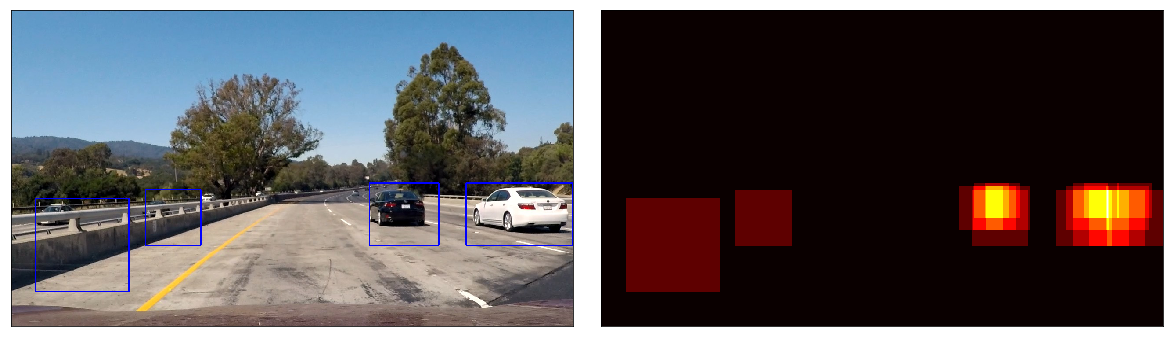

test_images/test5.jpg


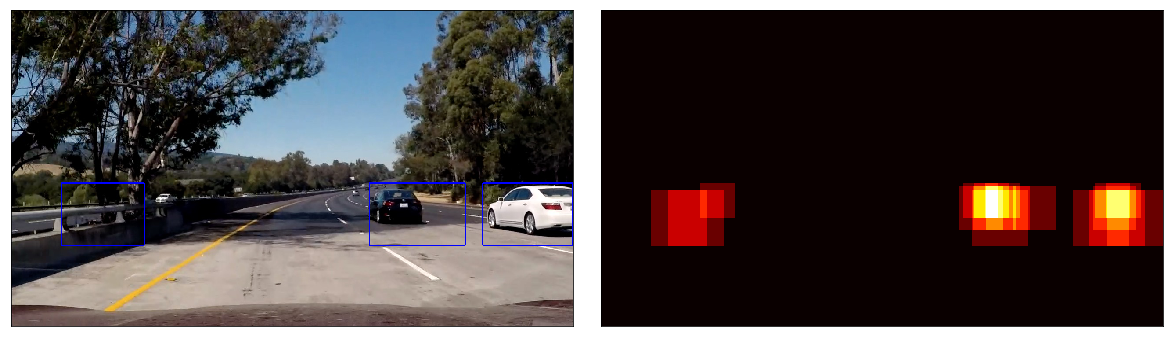

test_images/test3.jpg


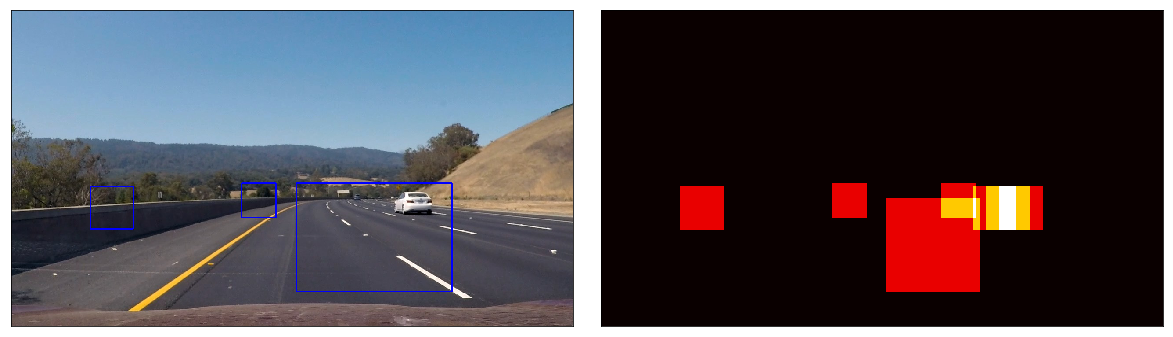

test_images/test2.jpg


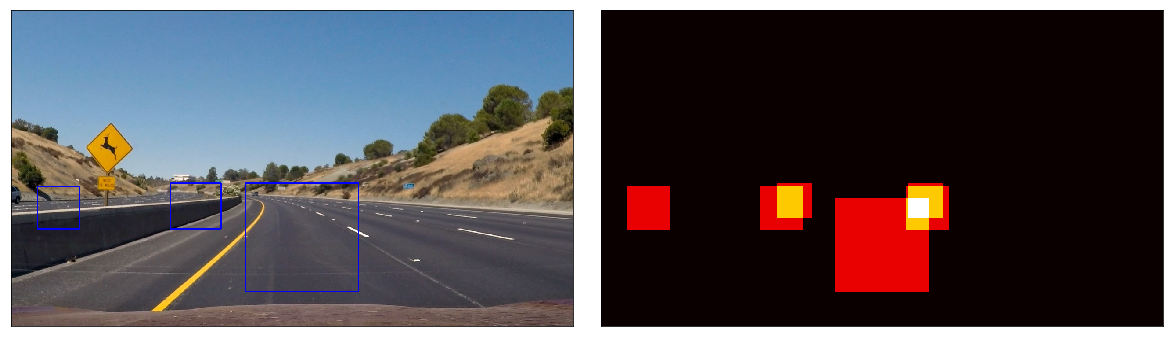

test_images/test6.jpg


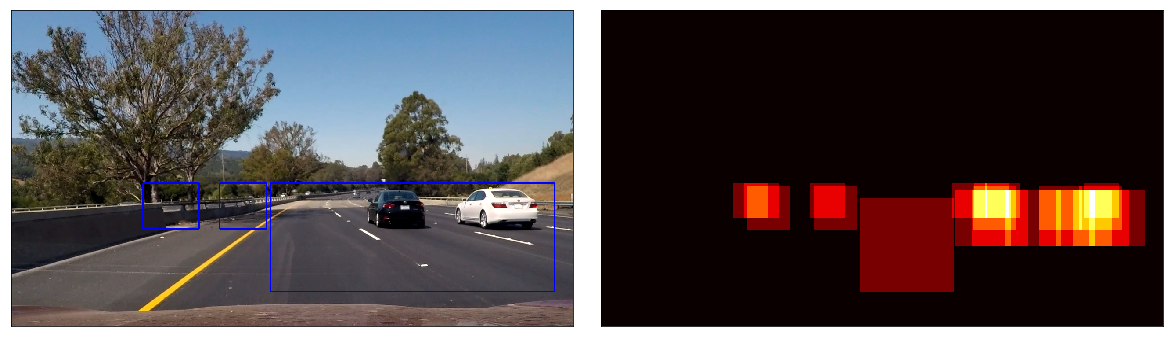

test_images/test4.jpg


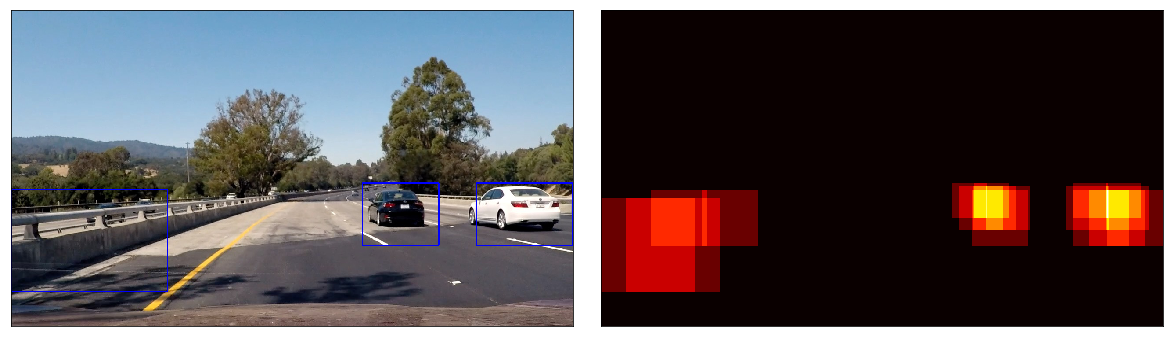

In [48]:
import imageio
imageio.plugins.ffmpeg.download()
from PIL import Image
import cv2

from moviepy.editor import VideoFileClip
#%matplotlib inline
for image_name in glob.glob('test_images/*.jpg'):
    print(image_name)
    image = mpimg.imread(image_name)
    #image = cv2.imread(image_name)
    #print(image)

    #image = Image.open(image_name)
    tracker = VehicleTracker(X_scaler, svc, image)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()

In [50]:
from moviepy.editor import VideoFileClip

video_output_name = 'project_video_annotated_vehicles.mp4'
video = VideoFileClip("project_video.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video project_video_annotated_vehicles.mp4
[MoviePy] Writing video project_video_annotated_vehicles.mp4


100%|█████████▉| 1260/1261 [30:55<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated_vehicles.mp4 

CPU times: user 31min 30s, sys: 7min 50s, total: 39min 20s
Wall time: 30min 57s
